In [1]:
import duckdb
import os
import polars as pl
import poldantic as pd
import polars.selectors as cs

import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
import markdown
import requests
import re
import concurrent.futures

from markdownify import markdownify as md

from lib.models import Post,Section,posts_schema
from lib.transform import transform_api_results
from lib.tree_functions import import_tree_from_json, find_node_by_id
from lib.config import pipeline_name, db_name, tree_json_path, download_subpage
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import time
import tempfile
from sqlalchemy import create_engine
import urllib
from pydantic import BaseModel
from typing import Dict, Any, Union

In [ ]:
base_url = "https://cdl-segg.fra1.cdn.digitaloceanspaces.com/cdl-segg/"
tree_url = base_url + "downloads_tree.json"
response = requests.get(tree_url)
response.raise_for_status()
with tempfile.NamedTemporaryFile(delete=False, suffix=".json") as temp_file:
    temp_file.write(response.content)
    path = temp_file.name
    root_node = import_tree_from_json(path)
    
print(root_node)

AnyNode(data_id='36', data_level='0', data_parent_id='0', name='Pimp my School Downloads')


In [4]:
df_posts = transform_api_results(pipeline_name, db_name)
df_posts.cast(posts_schema)

ColumnNotFoundError: download_chapter_dedicated

In [5]:
posts_parquet_url = "https://cdl-segg.fra1.cdn.digitaloceanspaces.com/cdl-segg/posts.parquet"
response = requests.get(posts_parquet_url)
response.raise_for_status()
schema = pd.to_polars_schema(Post)
posts_schema["_dlt_load_id"] = pl.Utf8
posts_schema["_dlt_id"] = pl.Utf8
print(schema)
df = pl.read_parquet(response.content).cast(posts_schema)





{'id': Int64, 'date': Date, 'title': String, 'stage': Object, 'tool_types': List(Object), 'topics': List(String), 'download_chapter_dedicated': Int64, 'download_chapters_further': List(Int64), 'book_chapter': String, 'related_posts': List(Int64)}


InvalidOperationError: conversion from `str` to `enum` failed in column 'tool_types' for 2 out of 2 values: ["["praesentation"]", "["praesentation"]"]

Ensure that all values in the input column are present in the categories of the enum datatype.

In [ ]:
schema

{'id': Int64,
 'date': Date,
 'title': String,
 'stage': String,
 'tool_types': String,
 'topics': String,
 'download_chapter_dedicated': Int64,
 'download_chapters_further': String,
 'book_chapter': String,
 'related_posts': String,
 '_dlt_load_id': String,
 '_dlt_id': String}

In [ ]:
df["stage"].value_counts().sort("count", descending=True)

stage,count
str,u32
"""grundlagen""",10
"""profis""",5
"""sv-alltag""",3
null,1
"""fortgeschrittene""",1


In [ ]:
df["stage"].unique().to_list()

['grundlagen', 'profis', 'sv-alltag', None, 'fortgeschrittene']

In [ ]:
def count_plot(df, col):
    lst = [x for xs in df[col] for x in xs]

    series = pl.Series(col, lst)
    counts_df = (
        pl.DataFrame([series])
        .unpivot()
        .group_by("value")
        .len()
        .sort("len", descending=True)
        .rename({"value": col, "len": "count"})
    )

    sns.barplot(data=counts_df, y=col, x="count", order=counts_df[col])
    plt.show()

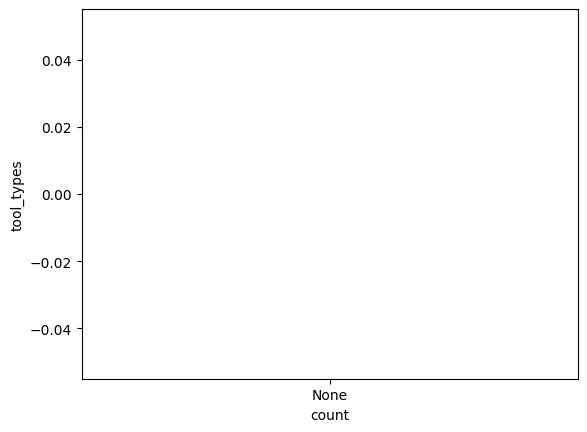

In [ ]:
count_plot(df, "tool_types")

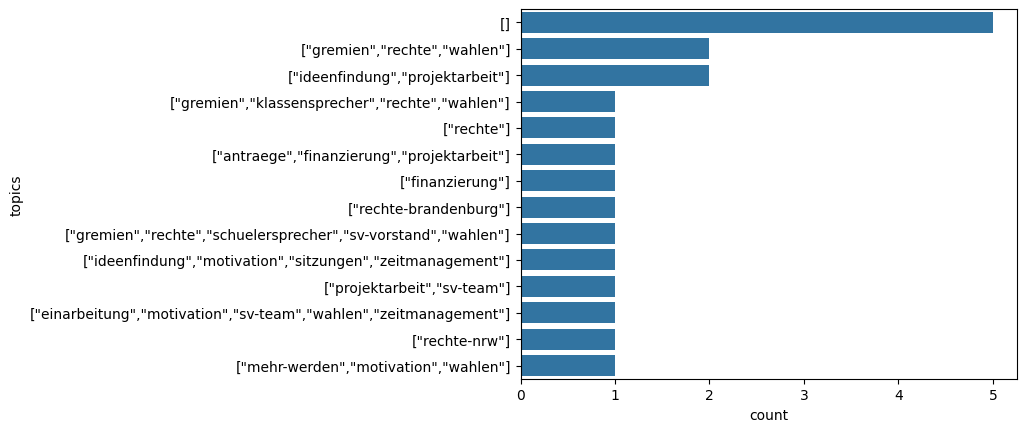

In [ ]:
count_plot(df, "topics")

### Download File Types

In [ ]:
with duckdb.connect(f"{pipeline_name}.duckdb", read_only=False) as db:
    df_downloads = db.sql(f"SELECT * FROM {db_name}.downloads").pl()

assert len(df_downloads) == len(df_downloads["data_id"].unique())

df_downloads["file_type"].value_counts()

file_type,count
str,u32
"""mp4""",4
"""pdf""",57
"""octet-stream""",12
"""png""",1
"""jpeg""",3
